<a href="https://colab.research.google.com/github/google/jax-md/blob/neighborlist_refactor/notebooks/nve_neighbor_list.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space
from jax_md import smap
from jax_md import energy
from jax_md import quantity
from jax_md import simulate
from jax_md import partition

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

  Cloning https://github.com/google/jax-md (to revision neighborlist_refactor) to /tmp/pip-req-build-jj796kpb
  Running command git clone -q https://github.com/google/jax-md /tmp/pip-req-build-jj796kpb
  Running command git checkout -b neighborlist_refactor --track origin/neighborlist_refactor
  Switched to a new branch 'neighborlist_refactor'
  Branch 'neighborlist_refactor' set up to track remote branch 'neighborlist_refactor' from 'origin'.


# Constant Energy Simulation With Neighbor Lists

Setup some system parameters.

In [3]:
Nx = particles_per_side = 80
spacing = np.float32(1.25)
side_length = Nx * spacing

R = onp.stack([onp.array(r) for r in onp.ndindex(Nx, Nx)]) * spacing
R = np.array(R, np.float64)

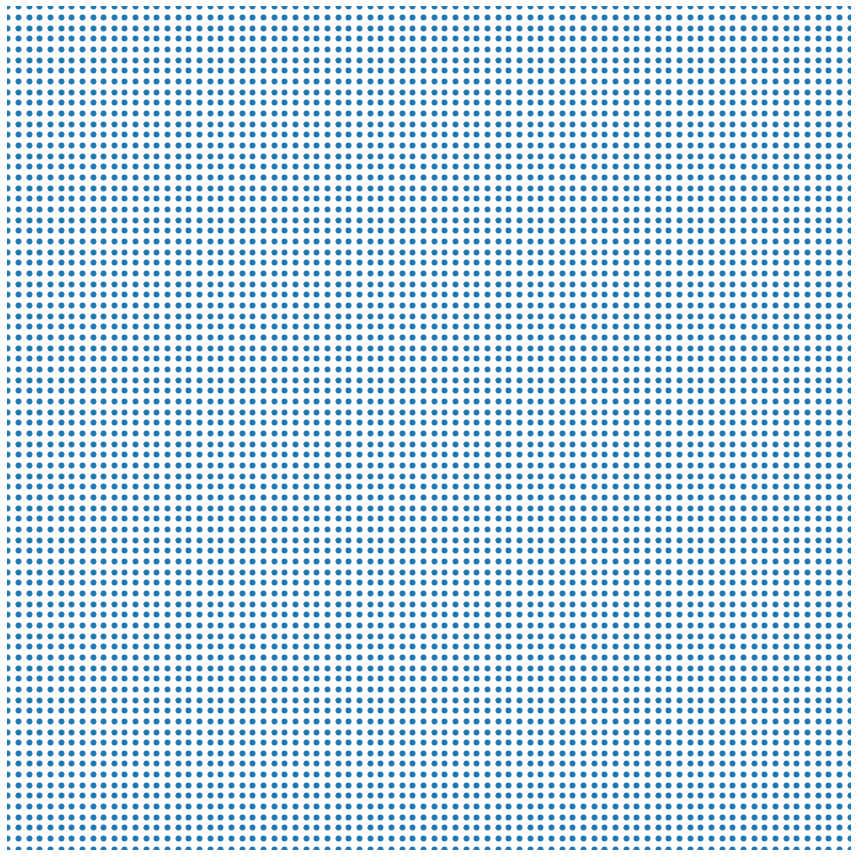

In [4]:
#@title Draw the initial state
ms = 10
R_plt = onp.array(R)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.5)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

JAX MD supports three different formats for neighbor lists: `Dense`, `Sparse`, and `OrderedSparse`. 

`Dense` neighbor lists store neighbor IDs in a matrix of shape `(particle_count, neighbors_per_particle)`. This can be advantageous if the system if homogeneous since it requires less memory bandwidth. However, `Dense` neighbor lists are more prone to overflows or waste if there are large fluctuations in the number of neighbors, since they must allocate enough capacity for the maximum number of neighbors.

`Sparse` neighbor lists store neighbor IDs in a matrix of shape `(2, total_neighbors)` where the first index specifies senders and receivers for each neighboring pair. Unlike `Dense` neighbor lists, `Sparse` neighbor lists must store two integers for each neighboring pair. However, they benefit because their capacity is bounded by the total number of neighbors, making them more efficient when different particles have different numbers of  neighbors.

`OrderedSparse` neighbor lists are like `Sparse` neighbor lists, except they only store pairs of neighbors `(i, j)` where `i < j`. For potentials that can be phrased as $\sum_{i<j}E_{ij}$ this can give a factor of two improvement in speed.

In [8]:
# format = partition.Dense
# format = partition.Sparse
format = partition.OrderedSparse

Construct two versions of the energy function with and without neighbor lists.

In [9]:
displacement, shift = space.periodic(side_length)

neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(displacement, 
                                                            side_length,
                                                            format=format)
energy_fn = jit(energy_fn)

exact_energy_fn = jit(energy.lennard_jones_pair(displacement))

To use a neighbor list, we must first allocate it. This step cannot be Just-in-Time (JIT) compiled because it uses the state of the system to infer the capacity of the neighbor list (which involves dynamic shapes).

In [12]:
nbrs = neighbor_fn.allocate(R)

Now we can compute the energy with and without neighbor lists. We see that both results agree, but the neighbor list version of the code is significantly faster.

In [13]:
# Run once so that we avoid the jit compilation time.
print('E = {}'.format(energy_fn(R, neighbor=nbrs)))
print('E_ex = {}'.format(exact_energy_fn(R)))

E = -11526.081609728004
E_ex = -11526.081609728013


In [15]:
%%timeit
energy_fn(R, neighbor=nbrs).block_until_ready()

The slowest run took 11.43 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 58.5 µs per loop


In [16]:
%%timeit
exact_energy_fn(R).block_until_ready()

1000 loops, best of 5: 1.08 ms per loop


Now we can run a simulation. Inside the body of the simulation, we update the neighbor list using `nbrs.update(position)`. This can be JIT, but it also might lead to buffer overflows if the allocated neighborlist cannot accomodate all of the neighbors. Therefore, every so often we check whether the neighbor list overflowed and if it did, we reallocate it using the state right before it overflowed. 

In [18]:
displacement, shift = space.periodic(side_length)

init_fn, apply_fn = simulate.nve(energy_fn, shift, 1e-3)
state = init_fn(random.PRNGKey(0), R, kT=1e-3, neighbor=nbrs)

def body_fn(i, state):
  state, nbrs = state
  nbrs = nbrs.update(state.position)
  state = apply_fn(state, neighbor=nbrs)
  return state, nbrs

step = 0
while step < 40:
  new_state, nbrs = lax.fori_loop(0, 100, body_fn, (state, nbrs))
  if nbrs.did_buffer_overflow:
    print('Neighbor list overflowed, reallocating.')
    nbrs = neighbor_fn.allocate(state.position)
  else:
    state = new_state
    step += 1

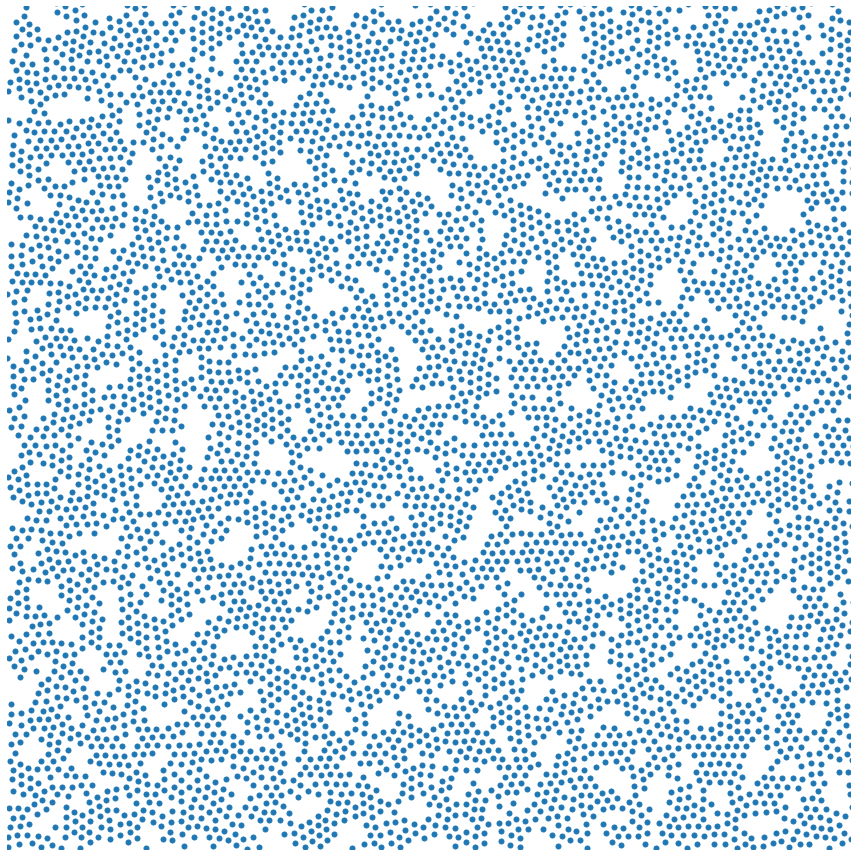

In [19]:
#@title Draw the final state
ms = 10
R_plt = onp.array(state.position)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.5)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))